In [14]:
%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
%pip install matplotlib yfinance scikit-learn scikit-optimize


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from river import metrics

# Importando as classes refatoradas
from utils.SeriesProcessor import SeriesProcessor
from utils.ModelTrainer import ModelTrainer
from utils.DriftEvaluator import DriftEvaluator
from utils.Visualizer import Visualizer
from utils.Optimizer import Optimizer
from utils.SaveCSV import SaveCSV
import pandas as pd

# Importando as classes existentes de otimização
from classes.otimizador.OtimizadorBayesiano import OtimizadorBayesiano

# 1. Importar os modelos e detectores de drift

In [17]:
# Importando detectores de drift
from classes.detectores.ADWINDetector import ADWINDetector
from classes.detectores.DDMDetector import DDMDetector
from classes.detectores.EDDMDetector import EDDMDetector
from classes.detectores.FHDDMDetector import FHDDMDetector
from classes.detectores.HDDM_ADetector import HDDM_ADetector
from classes.detectores.PageHinkleyDetector import PageHinkleyDetector
from classes.detectores.HDDM_WDetector import HDDM_WDetector
from classes.detectores.KSWINDetector import KSWINDetector

# Importando modelos offline
from classes.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from classes.modelosOffline.KneighborsRegressorModelo import KNeighborsRegressorModelo
from classes.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from classes.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from classes.modelosOffline.SVRModelo import SVRModelo
from classes.modelosOffline.RandomForestModelo import RandomForestModelo
from classes.modelosOffline.MLPRegressorModelo import MLPRegressorModelo

# Importando modelos online
from classes.modelosOnline.BayesianLinearRegressionModelo import BayesianLinearRegressionModelo
from classes.modelosOnline.HoeffdingTreeRegressorModelo import HoeffdingTreeRegressorModelo
from classes.modelosOnline.KNNRegressorOnlineModelo import KNNRegressorOnlineModelo
from classes.modelosOnline.LinearRegressionOnlineModelo import LinearRegressionOnlineModelo

# 2. Baixar e preparar os dados

In [18]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

In [19]:
# Definindo parâmetros para processamento
tamanho_batch = 50
lags = 5
serie_escolhida = series[-2]
print(f"Processando série: {serie_escolhida}")

# Baixando os dados da ação
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal.shape}")

# Gerando janelas temporais
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal, lags)
print(f"Shape dos dados de entrada: {X.shape}")
print(f"Shape dos dados de saída: {Y.shape}")

Processando série: ^BVSP


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1245, 1)
Shape dos dados de entrada: (1240, 5)
Shape dos dados de saída: (1240, 1)


# 3. Otimização de Hiperparâmetros

In [20]:
# Controle para executar ou pular otimização
executar_otimizacao = False #Mude para True quando quiser otimizar novamente

if executar_otimizacao:
    # Lista de modelos a otimizar (classes)
    modelos_offline = [
        LinearRegressionModelo,
        KNeighborsRegressorModelo,
        LassoRegressionModelo,
        #MLPRegressorModelo,  # Comentado por ser mais lento
        RandomForestModelo,
        RidgeRegressionModelo,
        SVRModelo
    ]

    modelos_online = [
        BayesianLinearRegressionModelo,
        HoeffdingTreeRegressorModelo,
        KNNRegressorOnlineModelo,
        LinearRegressionOnlineModelo
    ]

    # Inicializar o otimizador
    optimizer = OtimizadorBayesiano(n_iter=20, cv=3, random_state=42)

    # Otimizando todos os modelos
    modelos_otimizados, parametros_otimizados = Optimizer.otimizar_modelos_offline(
        X, Y, tamanho_batch, lags=lags, optimizer=optimizer,
        modelos_offline=modelos_offline,
    )

    # Salvar parâmetros otimizados para uso futuro
    import json
    with open('parametros_otimizados.json', 'w') as f:
        # Converter valores não serializáveis para strings
        params_serializaveis = {}
        for modelo, params in parametros_otimizados.items():
            params_serializaveis[modelo] = {k: str(v) for k, v in params.items()}
        json.dump(params_serializaveis, f, indent=4)

    print("Parâmetros otimizados salvos em 'parametros_otimizados.json'")
else:
    # Carregar parâmetros já otimizados
    import json
    import os
    import ast

    if os.path.exists('parametros_otimizados.json'):
        with open('parametros_otimizados.json', 'r') as f:
            params_carregados = json.load(f)

        # Convertendo strings de volta para valores adequados
        parametros_otimizados = {}
        for modelo, params in params_carregados.items():
            parametros_otimizados[modelo] = {}
            for k, v in params.items():
                # Tenta converter strings para valores Python
                try:
                    parametros_otimizados[modelo][k] = ast.literal_eval(v)
                except (ValueError, SyntaxError):
                    # Se falhar, mantém como string
                    parametros_otimizados[modelo][k] = v

        # Instanciando modelos com parâmetros otimizados
        modelos_otimizados = {}

        # Dicionário para mapear nomes de classes para referências reais de classes
        classes_modelos = {
            cls.__name__: cls for cls in
            [LinearRegressionModelo, KNeighborsRegressorModelo, LassoRegressionModelo,
             RandomForestModelo, RidgeRegressionModelo, SVRModelo,
             BayesianLinearRegressionModelo, HoeffdingTreeRegressorModelo,
             KNNRegressorOnlineModelo, LinearRegressionOnlineModelo]
        }

        for nome_modelo, params in parametros_otimizados.items():
            # Extrai o nome da classe do nome do modelo
            nome_classe = nome_modelo.split('_')[0]
            if nome_classe in classes_modelos:
                classe_modelo = classes_modelos[nome_classe]
                modelos_otimizados[nome_modelo] = classe_modelo(**params)
            else:
                print(f"Aviso: Classe {nome_classe} não encontrada!")

        print(f"Carregados {len(modelos_otimizados)} modelos com parâmetros otimizados")
    else:
        print("Arquivo de parâmetros não encontrado. Execute a otimização primeiro.")

Carregados 6 modelos com parâmetros otimizados


# 4. Executando Avaliação Prequential com Detecção de Drift

In [21]:
detector_escolhido = ADWINDetector

# Executando prequential com os modelos otimizados
resultados = {}
deteccoes_por_modelo = {}
dados_para_csv = []

for nome_modelo, modelo in modelos_otimizados.items():
    print(f"\nExecutando prequential para {nome_modelo}...")

    predicoes, deteccoes, mae, desvio_padrao = DriftEvaluator.prequential_batch(X, Y, tamanho_batch, modelo_classe=type(modelo), detector_classe=detector_escolhido)
    resultados[nome_modelo] = predicoes
    deteccoes_por_modelo[nome_modelo] = deteccoes
    num_deteccoes = len(deteccoes)

    print(f"Número de detecções para {nome_modelo}: {num_deteccoes}")

    dados_para_csv.append({
        'Modelo': nome_modelo,
        'Numero_Deteccoes': num_deteccoes,
        'MAE_Medio': mae.get(),
        'Std_Dev_Medio': desvio_padrao
    })

SaveCSV.salvar_resultados_csv(
    dados_para_csv,
    'resultados_prequential_deteccoes'
)


Executando prequential para LinearRegressionModelo...
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7f76b082bf20>
MAE Modelo Batch: [0.09365396]
Desvio Padrão dos Erros: 0.07558448738400753
Número de detecções para LinearRegressionModelo: 0

Executando prequential para KNeighborsRegressorModelo...

Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.

Mudança detectada no índice 416, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 415 até 465.

Mudança detectada no índice 912, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 911 até 961.
Modelo utilizado: <classes.modelosOffline.KneighborsRegressorModelo.KNeighborsRegressorModelo object at 0x7f76b083f9b0>
Detector utilizado: <classes.detectores.A

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 640, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 639 até 689.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 944, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 943 até 993.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7f76b07dcbc0>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7f76b07f2720>
MAE Modelo Batch: 0.4716395274897851
Desvio Padrão dos Erros: 0.5101721598162354
Número de detecções para RandomForestModelo: 3

Executando prequential para RidgeRegressionModelo...
Modelo utilizado: <classes.modelosOffline.RidgeRegressionModelo.RidgeRegressionModelo object at 0x7f76b08479e0>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7f76b07dd760>
MAE Modelo Batch: 0.102004814072594
Desvio Padrão dos Erros: 0.07838490727011833
Número de detecções para RidgeRegressionModelo: 0

Executando prequential para SVRModelo...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.

Mudança detectada no índice 416, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 415 até 465.

Mudança detectada no índice 656, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 655 até 705.

Mudança detectada no índice 928, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 927 até 977.
Modelo utilizado: <classes.modelosOffline.SVRModelo.SVRModelo object at 0x7f76b07de540>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7f76b07dd760>
MAE Modelo Batch: 0.6444182924942516
Desvio Padrão dos Erros: 0.685102076110487
Número de detecções para SVRModelo: 4

Resultados salvos em resultados_prequential_deteccoes.csv

Resumo dos Resultados:
 

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Nenhum drift detectado para LinearRegressionModelo.

Drift detectado para KNeighborsRegressorModelo nos índices: [176, 416, 912]

Drift detectado para LassoRegressionModelo nos índices: [176, 384, 720, 960]

Drift detectado para RandomForestModelo nos índices: [176, 640, 944]

Nenhum drift detectado para RidgeRegressionModelo.

Drift detectado para SVRModelo nos índices: [176, 416, 656, 928]


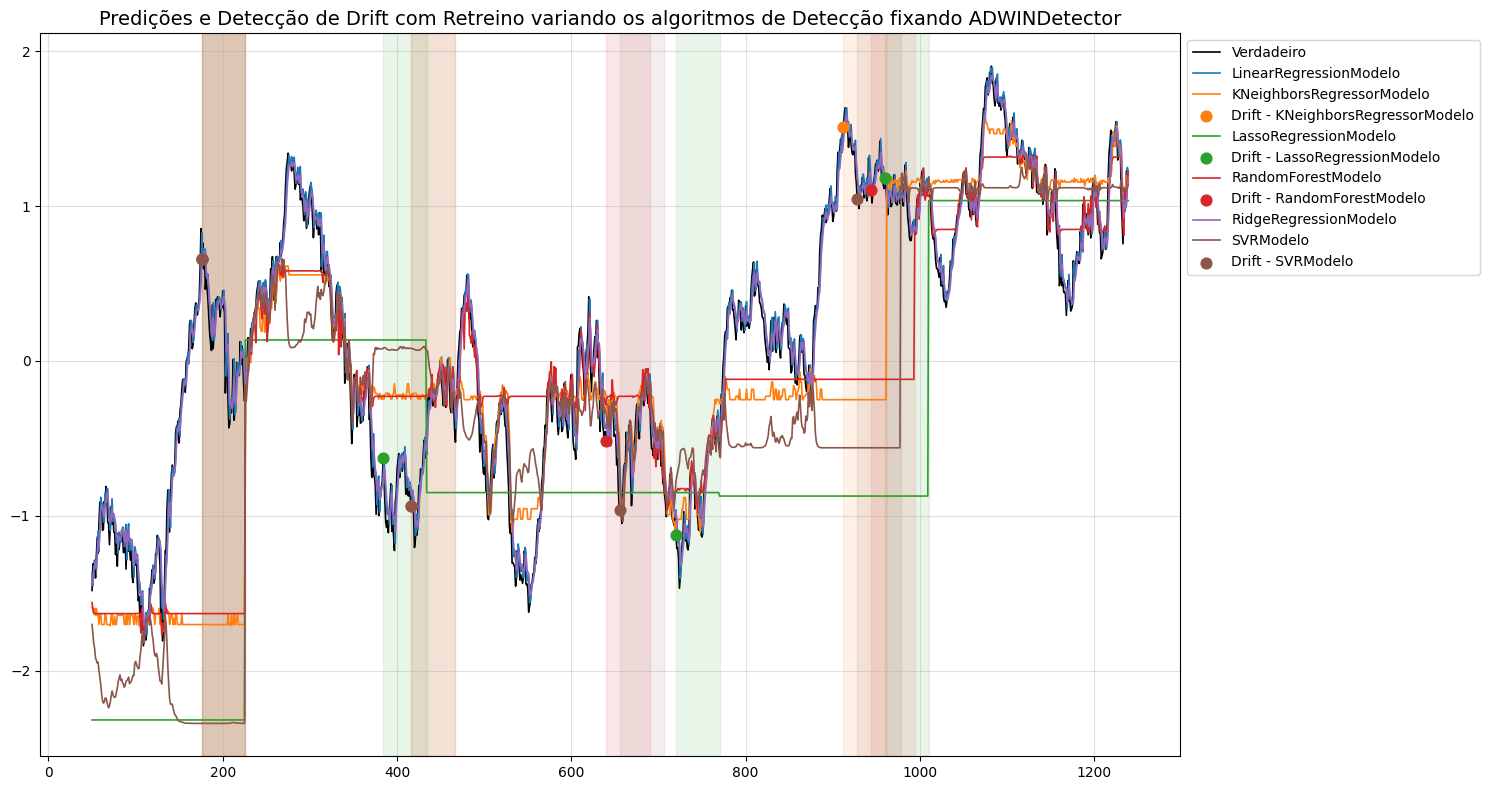

In [22]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  list(resultados.values()),
                  list(resultados.keys()),
                  deteccoes_por_modelo,
                  tamanho_batch,
                  detector_or_modelo="ADWINDetector",
                  )

# 5. Comparação de Detectores de Drift

In [23]:
modelo_escolhido = RandomForestModelo
print(f"Modelo selecionado para testes comparativos: {modelo_escolhido.__name__}")

# Lista de detectores a testar
detectores = [
    ADWINDetector,
    #DDMDetector,
    EDDMDetector,
    FHDDMDetector,
    HDDM_ADetector,
    PageHinkleyDetector,
    HDDM_WDetector,
    KSWINDetector
]

# Certifique-se que Y seja um array NumPy 1D, se necessário para prequential_batch
# y_true = np.array(Y).ravel() # Pode não ser necessário se prequential_batch lida com isso

resultados_detectores = {}
deteccoes_detectores = {}
dados_detectores_csv = []

for detector_classe in detectores:
    nome_detector = detector_classe.__name__
    print(f"\nTestando {nome_detector} com {modelo_escolhido.__name__}...")

    predicoes, deteccoes, mae_result, desvio_padrao_result = DriftEvaluator.prequential_batch(
        X, Y, tamanho_batch, modelo_classe=modelo_escolhido, detector_classe=detector_classe
    )

    resultados_detectores[nome_detector] = predicoes
    deteccoes_detectores[nome_detector] = deteccoes
    num_deteccoes = len(deteccoes)

    mae_valor = np.nan
    std_valor = np.nan
    try:
        temp_mae = mae_result.get() if hasattr(mae_result, 'get') else mae_result
        if isinstance(temp_mae, (list, np.ndarray)) and len(temp_mae) > 0:
            temp_mae = temp_mae[0]
        mae_valor = float(temp_mae)

        temp_std = desvio_padrao_result.get() if hasattr(desvio_padrao_result, 'get') else desvio_padrao_result
        if isinstance(temp_std, (list, np.ndarray)) and len(temp_std) > 0:
            temp_std = temp_std[0]
        std_valor = float(temp_std)

        print(f"  MAE Médio (retornado): {mae_valor:.4f}")
        print(f"  Desvio Padrão Médio dos Erros (retornado): {std_valor:.4f}")

    except (TypeError, IndexError, ValueError, AttributeError) as e:
        print(f"  Aviso: Não foi possível extrair valor numérico para MAE/StdDev retornado para {nome_detector}. Erro: {e}")

    print(f"  Número de detecções: {num_deteccoes}")

    dados_detectores_csv.append({
        'Detector': nome_detector,
        'MAE_Medio': mae_valor,
        'Std_Dev_Medio': std_valor,
        'Numero_Deteccoes': num_deteccoes
    })


df_resultados_detectores = pd.DataFrame(dados_detectores_csv)

nome_arquivo_csv_detectores = 'resultados_detectores_metricas.csv'
df_resultados_detectores.to_csv(nome_arquivo_csv_detectores, index=False, float_format='%.6f', na_rep='NaN')

print(f"\nResultados dos detectores salvos em {nome_arquivo_csv_detectores}")

print("\nResumo dos Resultados por Detector (Formatado):")

df_formatado_detectores = df_resultados_detectores.copy()

colunas_para_formatar = ['MAE_Medio', 'Std_Dev_Medio']
for col in colunas_para_formatar:
    if col in df_formatado_detectores.columns and pd.api.types.is_numeric_dtype(df_formatado_detectores[col]):
         df_formatado_detectores[col] = df_formatado_detectores[col].apply(lambda x: f'{x:.3f}' if pd.notna(x) else 'NaN')

print(df_formatado_detectores.to_string(index=False))

Modelo selecionado para testes comparativos: RandomForestModelo

Testando ADWINDetector com RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 672, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 671 até 721.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 944, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 943 até 993.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7f76b082a570>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7f76b02f3200>
MAE Modelo Batch: 0.5011920661349757
Desvio Padrão dos Erros: 0.5271332902108946
  MAE Médio (retornado): 0.5012
  Desvio Padrão Médio dos Erros (retornado): 0.5271
  Número de detecções: 3

Testando EDDMDetector com RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7f76b03a81d0>
Detector utilizado: <classes.detectores.EDDMDetector.EDDMDetector object at 0x7f76b07f39b0>
MAE Modelo Batch: 1.7290036527962553
Desvio Padrão dos Erros: 0.8634440259013575
  MAE Médio (retornado): 1.7290
  Desvio Padrão Médio dos Erros (retornado): 0.8634
  Número de detecções: 0

Testando FHDDMDetector com RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 372, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 371 até 421.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 743, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 742 até 792.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1186, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1185 até 1235.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7f76b083c3e0>
Detector utilizado: <classes.detectores.FHDDMDetector.FHDDMDetector object at 0x7f76b0379d90>
MAE Modelo Batch: 0.8035316687067218
Desvio Padrão dos Erros: 0.6909857391808909
  MAE Médio (retornado): 0.8035
  Desvio Padrão Médio dos Erros (retornado): 0.6910
  Número de detecções: 3

Testando HDDM_ADetector com RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 149, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 148 até 198.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 300, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 299 até 349.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 540, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 539 até 589.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 808, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 807 até 857.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 915, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 914 até 964.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1175, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1174 até 1224.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7f76b03a0260>
Detector utilizado: <classes.detectores.HDDM_ADetector.HDDM_ADetector object at 0x7f76b039fbc0>
MAE Modelo Batch: 0.3849016283391361
Desvio Padrão dos Erros: 0.4098603846865797
  MAE Médio (retornado): 0.3849
  Desvio Padrão Médio dos Erros (retornado): 0.4099
  Número de detecções: 6

Testando PageHinkleyDetector com RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 184, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 183 até 233.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 979, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 978 até 1028.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7f76d326fd70>
Detector utilizado: <classes.detectores.PageHinkleyDetector.PageHinkleyDetector object at 0x7f76b0379b80>
MAE Modelo Batch: 0.49942828128942346
Desvio Padrão dos Erros: 0.4952527260506487
  MAE Médio (retornado): 0.4994
  Desvio Padrão Médio dos Erros (retornado): 0.4953
  Número de detecções: 2

Testando HDDM_WDetector com RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 154, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 153 até 203.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 388, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 387 até 437.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 813, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 812 até 862.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1078, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1077 até 1127.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7f76b02ccec0>
Detector utilizado: <classes.detectores.HDDM_WDetector.HDDM_WDetector object at 0x7f76b09ba450>
MAE Modelo Batch: 0.46376045754484585
Desvio Padrão dos Erros: 0.4297225124756158
  MAE Médio (retornado): 0.4638
  Desvio Padrão Médio dos Erros (retornado): 0.4297
  Número de detecções: 4

Testando KSWINDetector com RandomForestModelo...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 152, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 151 até 201.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 300, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 299 até 349.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 453, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 452 até 502.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 601, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 600 até 650.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 749, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 748 até 798.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 897, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 896 até 946.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1045, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1044 até 1094.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1193, começando a coletar dados para retreino...
Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7f76b03b49e0>
Detector utilizado: <classes.detectores.KSWINDetector.KSWINDetector object at 0x7f76b09b8dd0>
MAE Modelo Batch: 0.3783754143327608
Desvio Padrão dos Erros: 0.42946002221633217
  MAE Médio (retornado): 0.3784
  Desvio Padrão Médio dos Erros (retornado): 0.4295
  Número de detecções: 8

Resultados dos detectores salvos em resultados_detectores_metricas.csv

Resumo dos Resultados por Detector (Formatado):
           Detector MAE_Medio Std_Dev_Medio  Numero_Deteccoes
      ADWINDetector     0.501         0.527                 3
       EDDMDetector     1.729         0.863                 0
      FHDDMDetector     0.804         0.691                 3
     HDDM_ADetector     0.385         0.410                 6
PageHinkleyDetector     0.499         0.495                 2
     HDDM_WDetector     0.464         


Drift detectado para ADWINDetector nos índices: [176, 672, 944]

Nenhum drift detectado para EDDMDetector.

Drift detectado para FHDDMDetector nos índices: [372, 743, 1186]

Drift detectado para HDDM_ADetector nos índices: [149, 300, 540, 808, 915, 1175]

Drift detectado para PageHinkleyDetector nos índices: [184, 979]

Drift detectado para HDDM_WDetector nos índices: [154, 388, 813, 1078]

Drift detectado para KSWINDetector nos índices: [152, 300, 453, 601, 749, 897, 1045, 1193]


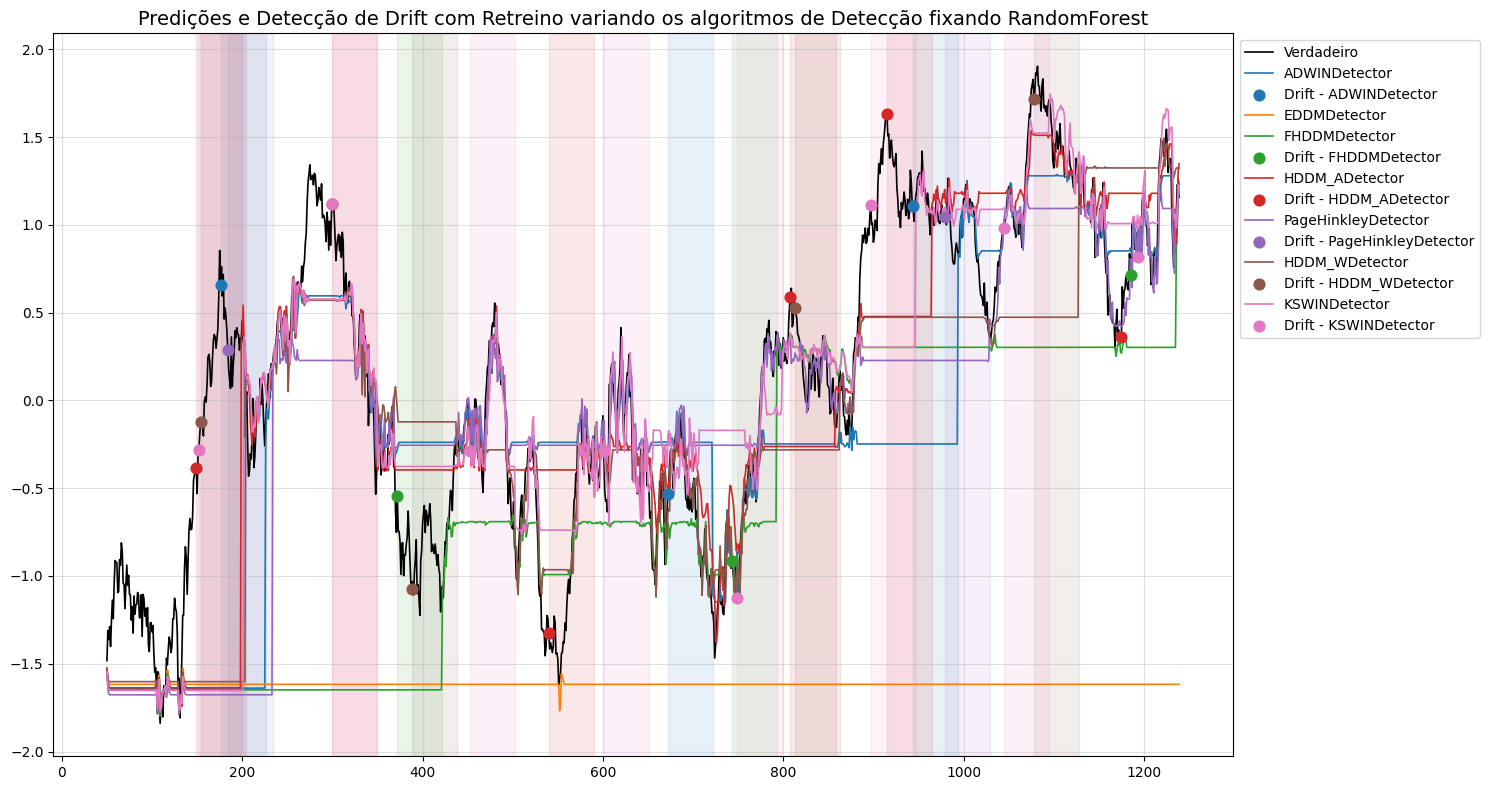

In [24]:
Visualizer.plotar_resultados_multi(Y,
                  list(resultados_detectores.values()),
                  list(resultados_detectores.keys()),
                  deteccoes_detectores,
                  tamanho_batch,
                  detector_or_modelo="RandomForest",
                  )

# 6. Resultado dos Modelos Online

In [25]:
resultados = {}
deteccoes_por_modelo = {}
dados_para_csv = []

modelos_online = [
        BayesianLinearRegressionModelo,
        HoeffdingTreeRegressorModelo,
        KNNRegressorOnlineModelo,
        LinearRegressionOnlineModelo
    ]

for modelo_classe in modelos_online:
    print(f"\nExecutando prequential para {modelo_classe.__name__}...")

    predicoes, mae, desvio_padrao = DriftEvaluator.prequential_passivo(X, Y, tamanho_batch, modelo_classe)
    resultados[modelo_classe.__name__] = predicoes

    dados_para_csv.append({
        'Modelo': modelo_classe.__name__,
        'MAE_Medio': mae.get(),
        'Std_Dev_Medio': desvio_padrao
    })

SaveCSV.salvar_resultados_csv(
    dados_para_csv=dados_para_csv,
    nome_arquivo_csv='resultados_prequential_passivo2'
)


Executando prequential para BayesianLinearRegressionModelo...
Modelo utilizado: <classes.modelosOnline.BayesianLinearRegressionModelo.BayesianLinearRegressionModelo object at 0x7f76b03aa7e0>
MAE Modelo Online: 0.09082080012235937

Executando prequential para HoeffdingTreeRegressorModelo...
Modelo utilizado: <classes.modelosOnline.HoeffdingTreeRegressorModelo.HoeffdingTreeRegressorModelo object at 0x7f76b02cd6d0>
MAE Modelo Online: 0.1145835292109634

Executando prequential para KNNRegressorOnlineModelo...
Modelo utilizado: <classes.modelosOnline.KNNRegressorOnlineModelo.KNNRegressorOnlineModelo object at 0x7f76b03a8770>
MAE Modelo Online: 0.11981561109580681

Executando prequential para LinearRegressionOnlineModelo...
Modelo utilizado: <classes.modelosOnline.LinearRegressionOnlineModelo.LinearRegressionOnlineModelo object at 0x7f76b09bb8f0>
MAE Modelo Online: 0.1145835292109634

Resultados salvos em resultados_prequential_passivo2.csv

Resumo dos Resultados:
                          


Nenhum drift detectado para BayesianLinearRegressionModelo.

Nenhum drift detectado para HoeffdingTreeRegressorModelo.

Nenhum drift detectado para KNNRegressorOnlineModelo.

Nenhum drift detectado para LinearRegressionOnlineModelo.


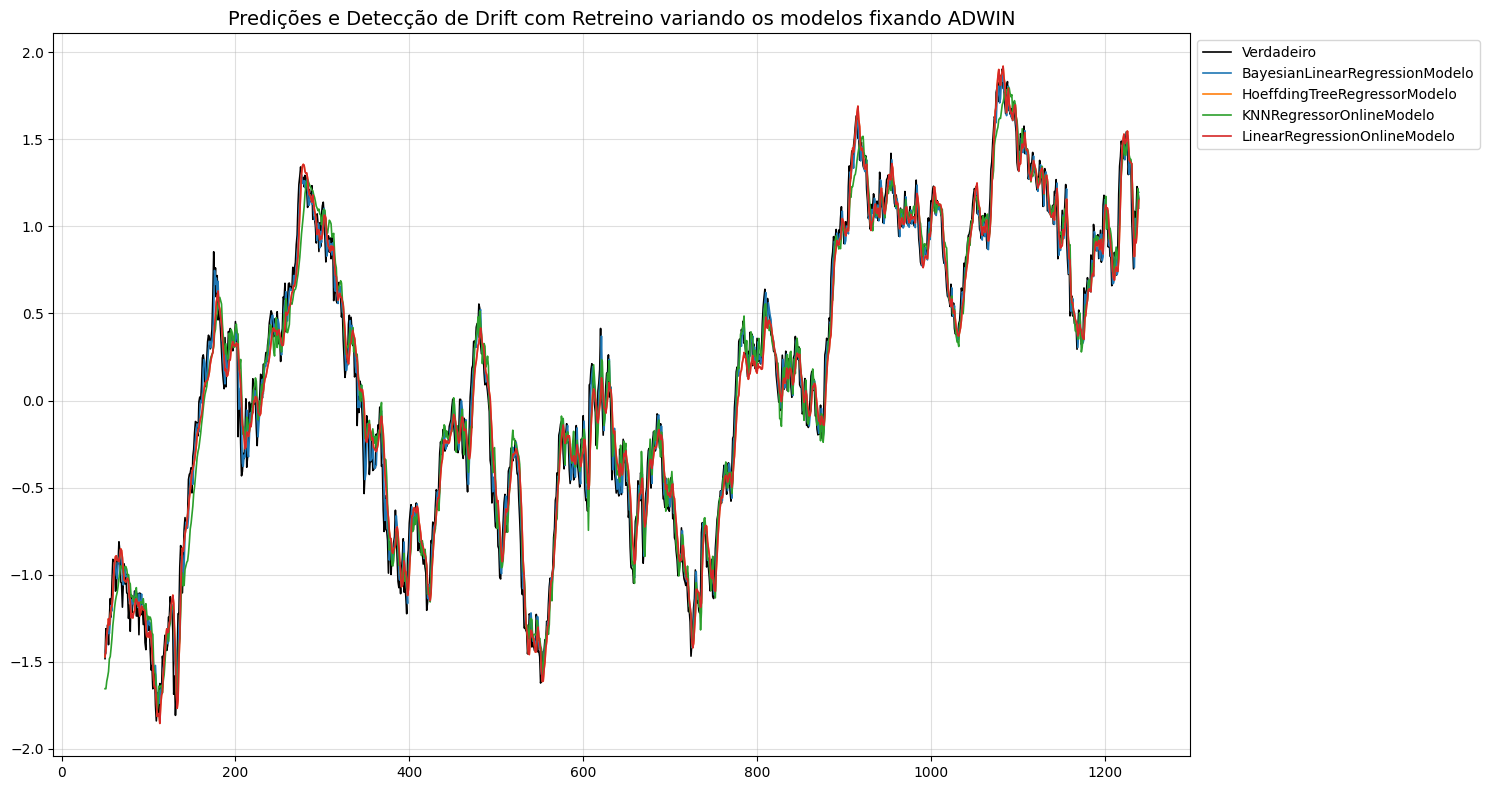

In [26]:
Visualizer.plotar_resultados(
    Y,
    list(resultados.values()),
    list(resultados.keys()),
    deteccoes_por_modelo={},
    tamanho_batch=tamanho_batch,
)